In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/gcolab/NYU_dl_course')

In [60]:
# Import dependencies
import random
import numpy as np
import torch
import torch.nn as nn

# You can find Alfredo's plotting code in plot_lib.py in this directory .
# Download it along with this assignment and keep it in the same directory.
from res.plot_lib import set_default, show_scatterplot, plot_bases

from matplotlib.pyplot import plot, title, axis

In [5]:
# Set up your device 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [6]:
# Set up random seed to 1008. Do not change the random seed.
# Yes, these are all necessary when you run experiments!
seed = 1008
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 1. Full, slice, fill
Write a function `warm_up` that returns the 2D tensor with integers below. **Do not use any loops**.

```
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 3 3 1 2 1 3 3 1 2 1
1 2 1 1 1 1 2 1 1 1 1 2 1
2 2 2 2 2 2 2 2 2 2 2 2 2
1 2 1 1 1 1 2 1 1 1 1 2 1
```


Hint: Use `torch.full`, `torch.fill_`, and the slicing operator.

In [17]:
def warm_up():
  matrix = torch.ones([13, 13], dtype=torch.uint8)

  matrix[1::5, :] = 2
  matrix[:, 1::5] = 2

  matrix[3::5, 3:4+1] = 3
  matrix[4::5, 3:4+1] = 3

  matrix[3::5, 8:9+1] = 3
  matrix[4::5, 8:9+1] = 3
  return matrix

# Uncomment line below once you implement this function. 
print(warm_up())

tensor([[1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 3, 3, 1, 2, 1, 3, 3, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1]], dtype=torch.uint8)


# 2. To Loop or not to loop

The motivation for the following three sub-questions is to get you to think critically about how to write your deep learning code. These sorts of choices can make the difference between tractable and intractable model training.

## 2.1. `mul_row_loop`
Write a function `mul_row_loop`, using python loops with simple indexing but no advanced indexing/slicing, that receives a 2D tensor as input and returns a tensor of same size that is 
- equal to the input on the first row
- 2 times the input's second row on the second row
- 3 times the input's third row on the third row
- etc..

For instance:
```
>>> t = torch.full((4, 8), 2.0)
>>> t
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.],
[2., 2., 2., 2., 2., 2., 2., 2.]])
>>> mul_row(t)
tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
[4., 4., 4., 4., 4., 4., 4., 4.],
[6., 6., 6., 6., 6., 6., 6., 6.],
[8., 8., 8., 8., 8., 8., 8., 8.]])
```

In [27]:
def mul_row_loop(input_tensor):
  res = input_tensor.clone()
  
  h, w = res.size()
  for i in range(h):
    for j in range(w):
      res[i][j] *= i+1

  return res

t = torch.full([4, 8], 2.0)
mul_row_loop(t)

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [4., 4., 4., 4., 4., 4., 4., 4.],
        [6., 6., 6., 6., 6., 6., 6., 6.],
        [8., 8., 8., 8., 8., 8., 8., 8.]])

# 2.2. `mul_row_fast`
Write a second version of the same function named `mul_row_fast` which uses tensor operations and no looping.

**Hint**: Use broadcasting and `torch.arange`, `torch.view`, and `torch.mul`.

In [37]:
def mul_row_fast(input_tensor):
  res = input_tensor.clone()
  n_rows = res.size()[0]
  rows = torch.arange(1, n_rows+1).view(n_rows, 1)
  res.mul_(rows)
  
  return res

t = torch.full([4, 8], 2.0)
mul_row_fast(t)

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [4., 4., 4., 4., 4., 4., 4., 4.],
        [6., 6., 6., 6., 6., 6., 6., 6.],
        [8., 8., 8., 8., 8., 8., 8., 8.]])

# 2.3. `times`
Write a function `times` which takes a 2D tensor as input and returns the run times of `mul_row_loop` and `mul_row_fast` on this tensor, respectively. Use `time.perf_counter`.

Use `torch.ones` to create a 2D tensor of size (1000, 400) full of ones and run `times` on it (there should be more than two orders of magnitude difference).

In [41]:
from time import perf_counter
def times(input_tensor):
    t1_s = perf_counter()
    mul_row_loop(input_tensor)
    t1 = perf_counter() - t1_s

    t2_s = perf_counter()
    mul_row_fast(input_tensor)
    t2 = perf_counter() - t2_s

    return (t1, t2)

# Uncomment lines below once you implement this function. 
input_tensor = torch.ones(1000, 400)
time_1, time_2 = times(input_tensor)
print(f'{time_1}, {time_2}')

5.996907758000816, 0.0007429799998135422


# 3. Non-linearities

In this section, we explore similar concepts to Lab 1 and get comfortable initializing modules like nn.Linear and using non-linearities in PyTorch.

## 3.1. ReLU
ReLU (Rectified Linear Unit) is a non-linear activation fuction defined as:

$$y = \mathrm{max}(0,x)$$

Define a fully connected neural network `linear_fc_relu` which:
- takes 2 dimensional data as input and passes it through linear modules (`torch.nn.Linear`)
- has one hidden layer of dimension 5 
- has output dimension of 2
- has ReLu as an activation function

Create a tensor with input data $X$ of size (100, 2) using `torch.randn`. 

Following the example in https://github.com/Atcold/pytorch-Deep-Learning-Minicourse/blob/master/02-space_stretching.ipynb, visualize the output of passing `X` through the neural network `linear_fc_relu`.

You can find Alfredo's plotting code in plot_lib.py in this directory. Download it along with this assignment and keep it in the same directory.

In [54]:
# Input data
X = torch.randn(10000, 2)
set_default((5,5))
colors = X[:, 0]

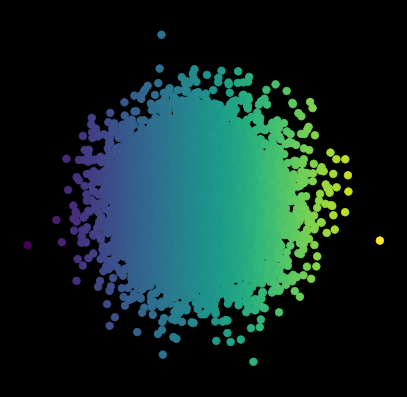

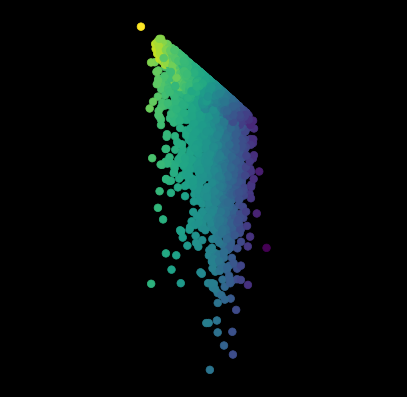

In [58]:
# create 1-layer neural networks with ReLU activation
n_hidden = 5

linear_fc_relu = nn.Sequential(
    nn.Linear(2, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 2)
)

linear_fc_relu.to(device)
with torch.no_grad():
  Y = linear_fc_relu(X)

show_scatterplot(X, colors)
show_scatterplot(Y, colors)
# Visualize: TODO

## 3.2. Sigmoid
The sigmoid function is another popular choice for a non-linear activation function which maps its input to values in the interval $(0,1)$. It is formally defined as:

$$\sigma(x) = \frac{1}{1+ exp[-x]}$$

Define a new neural network `linear_fc_sigmoid` which is the same architecture as in part `3.1.` but with a sigmoid unit instead of ReLU. 

Using the same $X$ as in part `3.1`, visualize the output of passing `X` through the neural network `linear_fc_sigmoid`.

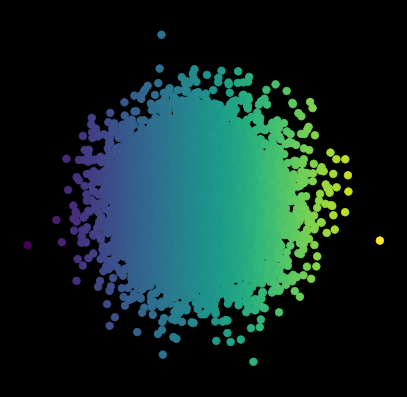

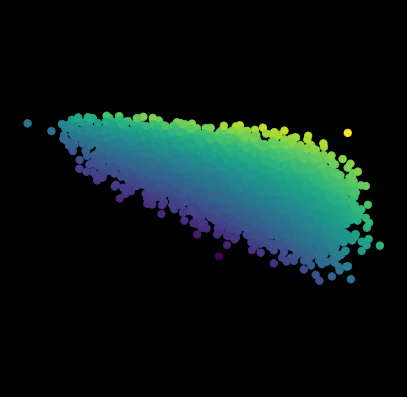

In [59]:
# create 1-layer neural networks with Sigmoid activation
n_hidden = 5

linear_fc_sigmoid = nn.Sequential(
    nn.Linear(2, n_hidden),
    nn.Sigmoid(),
    nn.Linear(n_hidden, 2)
)

linear_fc_sigmoid.to(device)
with torch.no_grad():
  Y = linear_fc_sigmoid(X)

show_scatterplot(X, colors)
show_scatterplot(Y, colors)